In [3]:
import numpy as np
import pandas as pd
import tqdm
import jax
import jax.numpy as jnp
import string
import tensorflow as tf
import time
from tqdm import tqdm

In [4]:
data = pd.read_csv('./data/raw data/raw_data.csv', header=0, names=['text'], usecols=[1])
print(f'Data Shape: {data.shape}')
data.head()

Data Shape: (13368, 1)


,text
0,"Sally Forrest, an actress-dancer who graced th..."
1,A middle-school teacher in China has inked hun...
2,A man convicted of killing the father and sist...
3,Avid rugby fan Prince Harry could barely watch...
4,A Triple M Radio producer has been inundated w...


In [5]:
# remove punctuation
punctuations = string.punctuation
def remove_punctuation(txt):
    for char in punctuations:
        if char in txt:
            txt = txt.replace(char, "")
    return txt

# change to lower caps
data['text'] = data['text'].str.lower()

# remove punctuations
data['text'] = data['text'].apply(remove_punctuation)

In [6]:
# split each row into list of words
data_lst = data['text'].apply(lambda txt: txt.split(" "))

# select number of rows to be used as training data
nrows = 200
random_indices = np.random.randint(low=0, high=len(data_lst), size=nrows)
data_lst = data_lst[random_indices].reset_index(drop=True)

print(f'Number of rows of data: {len(data_lst)}')
data_lst[:5]

Number of rows of data: 200


0    [celtic, star, mikael, lustig, has, revealed, ...
1    [in, a, new, twist, in, the, continuing, saga,...
2    [almost, 1000, migrants, have, been, rescued, ...
3    [her, choice, of, thighhigh, patent, boots, mi...
4    [in, the, closing, stages, of, the, rbs, 6, na...
Name: text, dtype: object

In [7]:
# vocab dict
vocab, index = {}, 1
vocab['<pad>'] = 0
for line in data_lst:
    for word in line:
        if word not in vocab:
            vocab[word] = index
            index += 1

# inverse_vocab dict
inverse_vocab = {}
for word, index in vocab.items():
    inverse_vocab[index] = word

print(f'Vocab size: {len(vocab)}')

Vocab size: 15740


In [8]:
# sequences
sequences = []
for line in data_lst:
    vectorized_line = [vocab[word] for word in line]
    sequences.append(vectorized_line)

In [ ]:
# create function that generates the skip gram samples
# def generate_training_data(sequences, window_size):
#     skip_grams = []
#     # for each sentence
#     for sequence in sequences:
#         for center_word_pos in range(len(sequence)):
#             # for each window position
#             for w in range(-window_size, window_size + 1):
#                 context_word_pos = center_word_pos + w
#                 # make soure not jump out sentence
#                 if context_word_pos < 0 or context_word_pos >= len(sequence) or center_word_pos == context_word_pos:
#                     continue
#                 context_word_idx = sequence[context_word_pos]
#                 skip_grams.append((sequence[center_word_pos], context_word_idx))

#     skip_grams = np.array(skip_grams) # it will be useful to have this as numpy array
#     return skip_grams

In [ ]:
# skip_grams = generate_training_data(sequences, 5)
# for target, context in skip_grams[:5]:
#     print(f'({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})')

In [9]:
# function to generate samples
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0,
          shuffle=True)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.reshape(tf.constant([context_word], dtype="int64"), (1,1))
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [10]:
# generate training data
window_size = 5
num_ns = 4
vocab_size = len(vocab)
seed = 4212

targets, contexts, labels = generate_training_data(sequences=sequences,
                                                 window_size=window_size,
                                                 num_ns=num_ns,
                                                 vocab_size=vocab_size,
                                                 seed=seed)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print(f'targets shape: {targets.shape}')
print(f'contexts shape: {contexts.shape}')
print(f'labels shape: {labels.shape}')

100%|██████████| 200/200 [03:36<00:00,  1.08s/it]


targets shape: (459218,)
contexts shape: (459218, 5)
labels shape: (459218, 5)


In [18]:
print(f"target_index    : {targets[0]}")
print(f"target_word     : {inverse_vocab[targets[0]]}")
print(f"context_indices : {contexts[0]}")
print(f"context_words   : {[inverse_vocab[c] for c in contexts[0]]}")
print(f"label           : {labels[0]}")

print("target  :", targets[0])
print("context :", contexts[0])
print("label   :", labels[0])

target_index    : 70
target_word     : which
context_indices : [  68   40 1656 1668 1114]
context_words   : ['injury', 'forced', 'failure', 'noted', 'husbands']
label           : [1 0 0 0 0]
target  : 70
context : [  68   40 1656 1668 1114]
label   : [1 0 0 0 0]


* Using negative sampling, the function to minimize

$$

\min_{\theta} = \frac{1}{N} \sum_{i=1}^{N} [log \sigma(u_{ic}^T)  + \sum_{k=1}^{K}log \sigma(-u_{kc}^T v_{iw})]

\\
\\
\theta = [U, V]

$$

In [19]:
# sigmoid function
def sigmoid(x):
    """Inputs a real number, outputs a real number"""
    return 1 / (1 + jnp.exp(-x))

# define a local loss function
# where it takes a params argument where params = [U, V]
# U and V are the embedding matrices. Dimension of U : (n x |v|), Dimension of V : (|v| x n)
# target is the index of the target word vector in the V matrix. Dimension: (1,)
# context is the index of the context word vectors in the U matrix. Dimension: (n,)
# returns a real number

def local_loss(params,
               target,
               context):
    """
    Input (example)
    target = (188,)
    context = (93, 40, 1648, 1659, 1109)
    params = [V, U]
        V: matrix of dim (n x |v|)
        U: matrix of dim (|v| x n)
            n = embedding dimension, |v| = vocab size

    Outputs the local_loss -> real number
    """
    target = target.astype(int)
    context = context.astype(int)
    V_embedding =params[0][0]
    U_embedding = params[0][1]
    
    v_t = V_embedding.T[target]; print(f'v_t shape: {v_t.shape}') # shape (300,)
    u_pos = U_embedding[context[0]]; print(f'u_pos shape: {u_pos.shape}')  # shape(300,)
    u_neg = U_embedding[context[1:]]; print(f'u_neg shape: {u_neg.shape}')  # shape(4, 300)

    return -jnp.log(sigmoid(jnp.dot(u_pos.T, v_t))) - jnp.sum(jnp.log(sigmoid(-jnp.dot(u_neg, v_t))))


In [14]:
# vmap the local loss across a batch of data points
loss_all = jax.vmap(local_loss, in_axes=(None, 0, 0))

@jax.jit
def loss(params, targets, contexts):
    """return average of all the local losses"""
    all_losses = loss_all(params, targets, contexts)
    return jnp.mean(all_losses)

# get the loss value and gradient
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [15]:
n = 100
v = len(vocab)
V_test = np.random.normal(0, 1, size=(n, v)) / np.sqrt(v)
U_test = np.random.normal(0, 1, size=(v, n)) / np.sqrt(v)
target_test = targets[0]
context_test = contexts[0]

local_loss([V_test, U_test], target_test, context_test)


v_t shape: ()
u_pos shape: ()
u_neg shape: (4,)


Array(3.4657307, dtype=float32)

In [20]:
# set up
n = 100
v = len(vocab)
V = np.random.normal(0, 1, size=(n, v)) / np.sqrt(v)
U = np.random.normal(0, 1, size=(v, n)) / np.sqrt(v)
params = [(V, U)]
targets_data = targets.astype(float)
contexts_data = contexts.astype(float)
labels_data = labels.astype(float)

print(f'V shape: {V.shape}')
print(f'U shape: {U.shape}')
print(f'targets_data shape: {targets_data.shape}')
print(f'contexts_data shape: {contexts_data.shape}')
print(f'labels_data shape: {labels_data.shape}')

V shape: (100, 15740)
U shape: (15740, 100)
targets_data shape: (459218,)
contexts_data shape: (459218, 5)
labels_data shape: (459218, 5)


In [17]:
# test if it works
# params = [V, U]
# print(f'loss: {loss(params, targets[:10], contexts[:10])}')
# v, g = loss_value_and_grad(params, targets[:10], contexts[:10])
# g[1].shape

v_t shape: ()
u_pos shape: ()
u_neg shape: (4,)
loss: 3.465703248977661


(15740, 100)

In [21]:
len(targets_data)

459218

In [29]:
# train using stochastic gradient descent

# number of training examples
N = len(targets_data)

# learning rate
lr = 1.

# number of epochs
n_epochs = 100

# batch size
batch_size = 1000

# number of batches per epoch
n_batches = N // batch_size

# keep track of losses
epoch_losses = []

# training the network
for epoch in range(n_epochs):
    # shuffle data
    perm = np.random.permutation(N)
    targets = targets[perm]
    contexts = contexts[perm]
    labels = labels[perm]

    # losses in each epoch
    losses = []
    for batch in range(n_batches):
        targets_batch = targets_data[batch*batch_size: (batch+1)*batch_size]
        contexts_batch = contexts_data[batch*batch_size: (batch+1)*batch_size]
        labels_batch = labels_data[batch*batch_size: (batch+1)*batch_size]

        # calculate and save losses
        loss_value, gradient = loss_value_and_grad(params, targets_batch, contexts_batch)
        losses.append(loss_value)

        params = [(V - lr*dV, U - lr*dU) for (V, U), (dV, dU) in zip(params, gradient)]
    
    epoch_losses.append(np.mean(losses))
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, loss = {np.mean(epoch_losses)}")


Epoch 1/100, loss = 1.5077515840530396
Epoch 11/100, loss = 1.4950178861618042
Epoch 21/100, loss = 1.4827665090560913
Epoch 31/100, loss = 1.4708513021469116
Epoch 41/100, loss = 1.4591195583343506
Epoch 51/100, loss = 1.4474422931671143
Epoch 61/100, loss = 1.4357260465621948
Epoch 71/100, loss = 1.4239155054092407
Epoch 81/100, loss = 1.411988377571106
Epoch 91/100, loss = 1.3999418020248413


Text(0, 0.5, 'Loss')

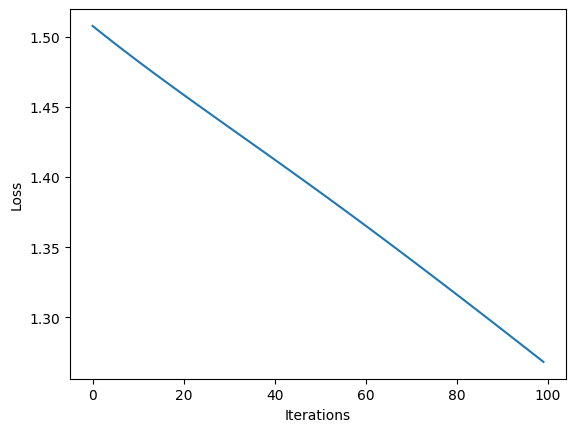

In [30]:
# plot losses
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [145]:
# train using stochastic gradient descent

# number of training examples
N = len(targets_data)

# learning rate
lr = 0.000000001

# number iterations
niter = 2000

# batch size
batch_size = 200

losses = []

# training the network
for it in range(niter):
    # select random batch of images
    indices = np.random.randint(low=0, high=N-1, size=batch_size)

    # calculate  and save loss
    loss_value, gradient = loss_value_and_grad(params, targets_data[indices], contexts_data[indices])
    losses.append(loss_value)

    # update params
    params = [(V - lr*dV, U - lr*dU) for (V, U), (dV, dU) in zip(params, gradient)]

    if it % 50 == 0:
        print(f"iteration:{it} \t loss={loss_value:2.4f}")

v_t shape: (100,)
u_pos shape: (100,)
u_neg shape: (4, 100)
iteration:0 	 loss=3.4658
iteration:50 	 loss=3.4657
iteration:100 	 loss=3.4657
iteration:150 	 loss=3.4658
iteration:200 	 loss=3.4658
iteration:250 	 loss=3.4657
iteration:300 	 loss=3.4658
iteration:350 	 loss=3.4657
iteration:400 	 loss=3.4657
iteration:450 	 loss=3.4658
iteration:500 	 loss=3.4658
iteration:550 	 loss=3.4657
iteration:600 	 loss=3.4657
iteration:650 	 loss=3.4657
iteration:700 	 loss=3.4657
iteration:750 	 loss=3.4658
iteration:800 	 loss=3.4657
iteration:850 	 loss=3.4657
iteration:900 	 loss=3.4657
iteration:950 	 loss=3.4658
iteration:1000 	 loss=3.4657
iteration:1050 	 loss=3.4656
iteration:1100 	 loss=3.4657
iteration:1150 	 loss=3.4657
iteration:1200 	 loss=3.4657
iteration:1250 	 loss=3.4658
iteration:1300 	 loss=3.4658
iteration:1350 	 loss=3.4657
iteration:1400 	 loss=3.4657
iteration:1450 	 loss=3.4658
iteration:1500 	 loss=3.4657
iteration:1550 	 loss=3.4657
iteration:1600 	 loss=3.4658
iterat

In [ ]:
# define a scoring metric to evaulate the quality of the word embeddings
